In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns


# Part 1:
### A) Find a linear regression model that relates the living area to the selling price. If you did any data cleaning step(s), describe and explain why you did that.

In [58]:
data = pd.read_csv('./Resources/data_assignment2.csv')

In [59]:
##First we look at the data to identify if there is a need for data cleaning.
#data
data.head(3)

,ID,Living_area,Rooms,Land_size,Biarea,Age,Selling_price
0,1,104,5.0,271.0,25.0,33,4600000
1,2,99,5.0,1506.0,6.0,88,4450000
2,3,133,6.0,486.0,NaN,44,4900000


In [60]:
## We notice some NaN values, however, if we drop them immediatley, we risk loosing data which we can use.
## First we identify which variables we want to use to fit the regression, as price is not only dependent on the living area.
## Due to: 
print('Min biarea:',data['Biarea'].min())
## We can also assume that NaN values represent plots where there is no additonal area and can thus replace NaN with 0.
data['Biarea'] = data['Biarea'].fillna(0)
## Now we only have one entry with a NaN value(row 18), and assuming all relevant property has rooms we should drop this entry.
data =data.dropna()
## We can add landsize and Biarea togehter as we assume that in the event of a sale essentially contribute equally to the selling-price.
data['Land_area_total'] = 0
data['Land_area_total'] = data['Land_size'] + data['Biarea']
## There does not seem to be any extreme outliers so we will not bother windsorizing the data.


Min biarea: 6.0


In [61]:
## To follow good statistical practice we will however check variables for multicolliniarity using the VIF method.
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(data):
    vif_data= pd.DataFrame()
    vif_data["variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return vif_data

print('First Iteration:',vif(data)) ## Since we have essentially put two variables together in Land_area_total there is multicollinearity. Remove those along with other extreme variables.
#A VIF above 10 indicates multicolliniarity, VIF under five is acceptable. We remove from highest order, starting with the dependent variable and the index.
vif_data = data.drop(columns=['ID','Selling_price','Biarea','Land_size'])
print('Second Iteration:',vif(vif_data))
#By the same logic, number of rooms and livingarea should in principle tell us the same information about the sellingprice, we remove the rooms.
vif_data = vif_data.drop(columns=['Rooms'])
print('Third Iteration:',vif(vif_data))
##As we see, we can not use any other variable than age, since there is multicollinearity, but for the sake of the assignment we continue with these variables.

            

First Iteration:           variable        VIF
0               ID   4.358253
1      Living_area  62.951614
2            Rooms  67.735694
3        Land_size        inf
4           Biarea        inf
5              Age   4.597778
6    Selling_price  28.574812
7  Land_area_total        inf
Second Iteration:           variable        VIF
0      Living_area  47.764172
1            Rooms  50.566761
2              Age   4.063140
3  Land_area_total   5.159818
Third Iteration:           variable       VIF
0      Living_area  3.392085
1              Age  3.433295
2  Land_area_total  5.086457


c:\Users\Johan Birgersson\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


<AxesSubplot:xlabel='Living_area', ylabel='Selling_price'>

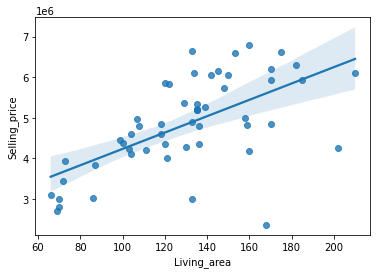

In [62]:
## Lets have a quick look at a quick regression plot, we find that there indeed seems to be a positive correlation between living area and sellingprice.
sns.regplot(data=data,x='Living_area',y='Selling_price')

In [63]:
## Running an initial OLS on these we find:
import statsmodels.formula.api as sm
result = sm.ols(formula="Selling_price ~ Living_area", data=data).fit()
#result.params
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Selling_price   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     30.66
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.08e-06
Time:                        14:47:09   Log-Likelihood:                -801.31
No. Observations:                  53   AIC:                             1607.
Df Residuals:                      51   BIC:                             1611.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     2.22e+06    4.9e+05      4.532      

In [64]:
## Highly significant coefficents (p<0.01), 
## Furhtermore, it seems to be a great explanatory variable as 
## it produced a high R-squared (ie. explaining a lot of the variation of sellingprice).
## Lets look at the coeffiients:
print('Intercept: ', result.params[0])
print('Living_area: ',result.params[1])

Intercept:  2219933.4687544852
Living_area:  20151.279523921763


### B) What are the values of the slope and intercept of the regression line?

In [65]:
## The intercept: The starting price in the sample, if the living area was zero, the sellingprice would be 2219933(SEK) According to this model.
## in reality this is ofcourse not the case, but given this one variable this is the models interpretation.
## Living_area: Each additional area of living space contributes 20151 (SEK) to the sellingprice. Ie a positive correlation. (Keep in mind there is multicollinearity)

In [66]:
print(data.columns)
result2 = sm.ols(formula="Selling_price ~ Living_area + Age", data=data).fit()
## When we add the age, variable we find greater R-squared and a highly significant negative correlation with the properties age and its price.
print(result2.summary())

Index(['ID', 'Living_area', 'Rooms', 'Land_size', 'Biarea', 'Age',
       'Selling_price', 'Land_area_total'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:          Selling_price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     27.55
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           8.60e-09
Time:                        14:47:09   Log-Likelihood:                -794.10
No. Observations:                  53   AIC:                             1594.
Df Residuals:                      50   BIC:                             1600.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.97

In [67]:
print('Intercept: ', result2.params[0])
print('Living_area: ', result2.params[1])
print('age: ', result2.params[2])

# Adding age as a factor, we get closer to explaining the selling price, indicated by the increase in r-squared. 
# We notice that the contribution of the living area could previously have been over-estimated since it decreased with a significant amount with the introduction of anohter variable.
# As we have not done any further measures to fit the model we will not rely on the numbers. 
# We can however reject the null hypothesis and confirm that living area has a positive effect on selling price and age of the house has a negative effect on selling price in our sample.


Intercept:  3643249.9367851815
Living_area:  14611.240988414904
age:  -17160.252184278757


### C) Use this model to predict the selling prices of houses which have living area 100 m2, 150 m2 and 200 m2.

In [68]:
## We use the first model for simplicity sake, not to incorporate the age variable.
print('Intercept: ', result.params[0])
print('Living_area: ',result.params[1])

Intercept:  2219933.4687544852
Living_area:  20151.279523921763


In [69]:
def predictedSellingprice(livingarea,model,rounded):
    return round((model.params[0]+(livingarea*model.params[1]))/1000000,rounded)

In [70]:
p_sellingprice = pd.DataFrame()
p_sellingprice['M2'] = ['100','150','200']
p_sellingprice['Predicted_price'] =[str(predictedSellingprice(100,result,4)) + ' MSEK', str(predictedSellingprice(150,result,4)) + ' MSEK', str(predictedSellingprice(200,result,4))+ ' MSEK']
p_sellingprice.index = p_sellingprice['M2']
p_sellingprice = p_sellingprice.drop(columns=['M2'])
p_sellingprice


,Predicted_price
M2,
100,4.2351 MSEK
150,5.2426 MSEK
200,6.2502 MSEK


### D) Draw a residual plot

In [71]:
fig = plt.figure(figsize=(14, 8))
# creating regression plots
fig = sm.graphics.plot_regress_exog(result,'Living_area',fig=fig)

AttributeError: module 'statsmodels.formula.api' has no attribute 'graphics'

<Figure size 1008x576 with 0 Axes>

eval_env: 1


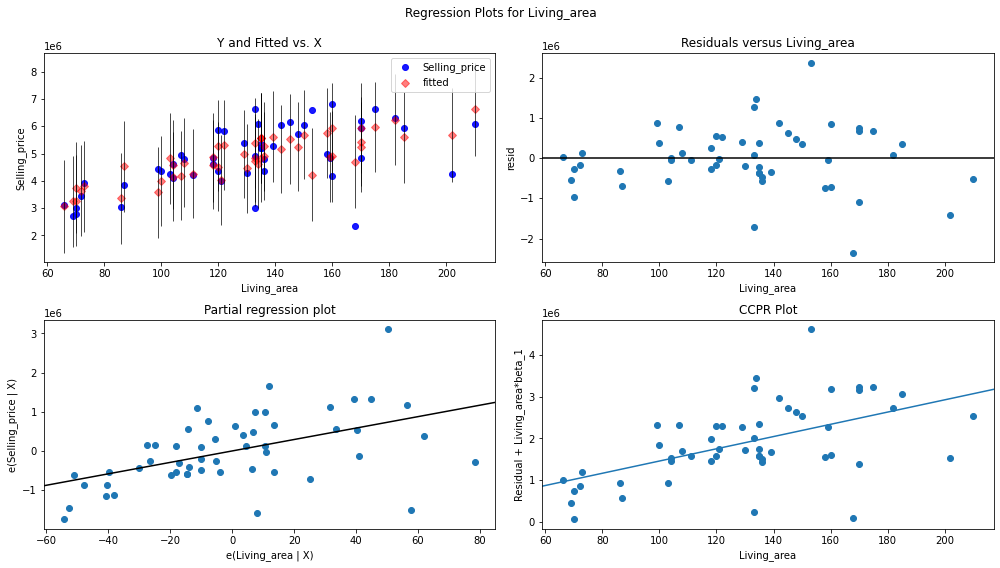

In [ ]:
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(result2,'Living_area',fig=fig)

### E) Discuss the results, and how the model could be improved
As we see from the top right, in both models, there is no dicernable pattern, there are however some outliers which we could have windsorized or utilized robust regression to handle, but we decided not to earlier as they are not extreme and will not affect much. In the bottom right, we notice the residuals are smaller when in relation to the other variable age. 

## Part 2:
#### A) Use a confusion matrix to evaluate the use of logistic regression to classify the iris data set:

The iris dataset contains data on petal and sepal size, these make up observations of three types of flowers, logistic regression should, given a new entry of data be able to predict which of the three flower categories it falls into.

In [100]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

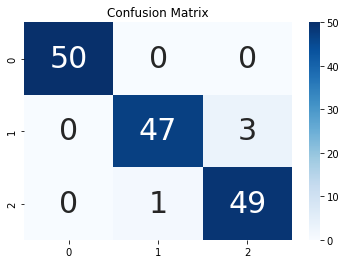

In [104]:
x_iris, y_iris = load_iris(return_X_y=True)

log_reg = LogisticRegression(max_iter=800).fit(x_iris, y_iris)

# Plot confusion matrix as  heatmap 
def plotcm(data):
    ax = plt.axes()
    df_cm = data
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
    ax.set_title('Confusion Matrix')
    plt.show()

plotcm(confusion_matrix(y_iris, log_reg.predict(x_iris)))

## With the first 

### B) Use k-nearest neighbours to classify the iris data set with some different
### values for k, and with uniform and distance-based weights. What will happen
### when k grows larger for the different cases? Why?

In [109]:
k_neighbors = [1, 2, 5, 7, 9, 13, 17, 23,50]
weights = ["uniform", "distance"]

for k in k_neighbors:
    for w in weights:
        knn_reg = KNeighborsClassifier(k, weights=w).fit(x_iris, y_iris) 
        print('K:'+str(k)+' weight:' + w +' score: '+ str(knn_reg.score(x_iris, y_iris)))


K:1 weight:uniform score: 1.0
K:1 weight:distance score: 1.0
K:2 weight:uniform score: 0.98
K:2 weight:distance score: 1.0
K:5 weight:uniform score: 0.9666666666666667
K:5 weight:distance score: 1.0
K:7 weight:uniform score: 0.9733333333333334
K:7 weight:distance score: 1.0
K:9 weight:uniform score: 0.98
K:9 weight:distance score: 1.0
K:13 weight:uniform score: 0.98
K:13 weight:distance score: 1.0
K:17 weight:uniform score: 0.98
K:17 weight:distance score: 1.0
K:23 weight:uniform score: 0.98
K:23 weight:distance score: 1.0
K:50 weight:uniform score: 0.94
K:50 weight:distance score: 1.0


### C) Compare the classification models for the iris data set that are generated by
### k-nearest neighbours (for the different settings from question 3) and by
### logistic regression. Calculate confusion matrices for these models and discuss
### the performance of the various models.

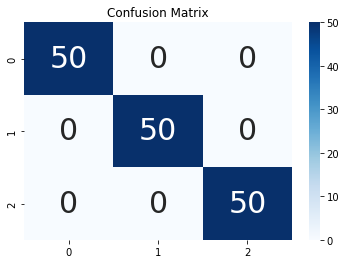

In [116]:
# Confusion matrix for K-nearest-neighbors
# Model selection
knn_reg = KNeighborsClassifier(2, weights="distance").fit(x_iris, y_iris)

plotcm(confusion_matrix(y_iris, knn_reg.predict(x_iris)))




## Part 3:

To confirm a change we need to confirm the baseline. etc.